# Домашнее задание 1

Выполнил Козин Роман

## Вариант 3

Цель: Создание компактной сети.

* Создайте архитектуру, используя не более 50 000 параметров.
* Условие: Один слой должен быть 1x1 сверткой, чтобы уменьшить число каналов.
* Эксперимент: Подсчитайте количество параметров каждого слоя и убедитесь, что общая сумма не превышает лимита.

Предположим, что наша модель будет использоваться для обработки RGB-изображений размера 32х32. Создадим несколько свёрточных слоёв, чтобы выделить признаки на изображении, потом выпрямим признаки и применим полносвязный слой.

Количество параметров свёртки:

$$
    n = out_{ch} \cdot \left( in_{ch} \cdot ker_{w} \cdot ker_{h} + 1 \right)
$$

Количество параметров полносвязного слоя:

$$
    m = out_{ch} \cdot \left( in_{ch} + 1 \right)
$$

In [7]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1) # 16 * (3 * 3 * 3 + 1) = 448 параметров
        self.avgPool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.convLayer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1) # 32 * (16 * 9 + 1) = 4640 параметров
        self.convLayer3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1,stride=1) # 16 * (32 * 1 + 1) = 528 параметров
        self.FC1 = nn.Linear(in_features=576, out_features=64) #выход последней свёртки: 16 х 6 х 6; 64 * (576 + 1) = 36928 параметров
        self.FC2 = nn.Linear(in_features=64, out_features=10) # 10 * (64 + 1) = 650 параметров
        self.activation = nn.Tanh()
        self.softMax = nn.Softmax()
        
    def forward(self, x):
        x = self.avgPool(self.activation(self.convLayer1(x)))
        x = self.avgPool(self.activation(self.convLayer2(x)))
        x = self.activation(self.convLayer3(x))
        x = x.view(-1, 576)
        x = self.activation(self.FC1(x))
        x = self.softMax(self.FC2(x))
        return x

Итого получили 43194 параметров, проверим, что не ошиблись в подсчёте

In [8]:
from torchsummary import summary

model = Model()
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─AvgPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            528
├─Linear: 1-5                            36,928
├─Linear: 1-6                            650
├─Tanh: 1-7                              --
├─Softmax: 1-8                           --
Total params: 43,194
Trainable params: 43,194
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─AvgPool2d: 1-2                         --
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            528
├─Linear: 1-5                            36,928
├─Linear: 1-6                            650
├─Tanh: 1-7                              --
├─Softmax: 1-8                           --
Total params: 43,194
Trainable params: 43,194
Non-trainable params: 0

Количество параметров совпало и оно меньше 50000, также используется 1х1 свёртка для уменьшения числа каналов

## Вариант 6

Цель: Сравнение MaxPool и Global Average Pooling.

* Спроектируйте сеть для входа (3, 64, 64) и выхода (32, 8, 8).
* Условие: В сети обязательно должны быть и MaxPool2d, и AdaptiveAvgPool2d.
* Эксперимент: Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре, визуализируйте карты признаков и среднее значение активаций.

In [9]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2) 
        self.convLayer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1) 
        self.activation = nn.ReLU()
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(8)
        
    def forward(self, x):
        x = self.activation(self.convLayer1(x))
        x = self.activation(self.convLayer2(x))
        return self.maxPool(x), self.gap(x)

In [10]:
torch.manual_seed(0)
inpt = torch.randn(size=(3,64,64))
model = Model()
maxPool, gap = model(inpt)
print(maxPool.shape, gap.shape)

torch.Size([32, 8, 8]) torch.Size([32, 8, 8])


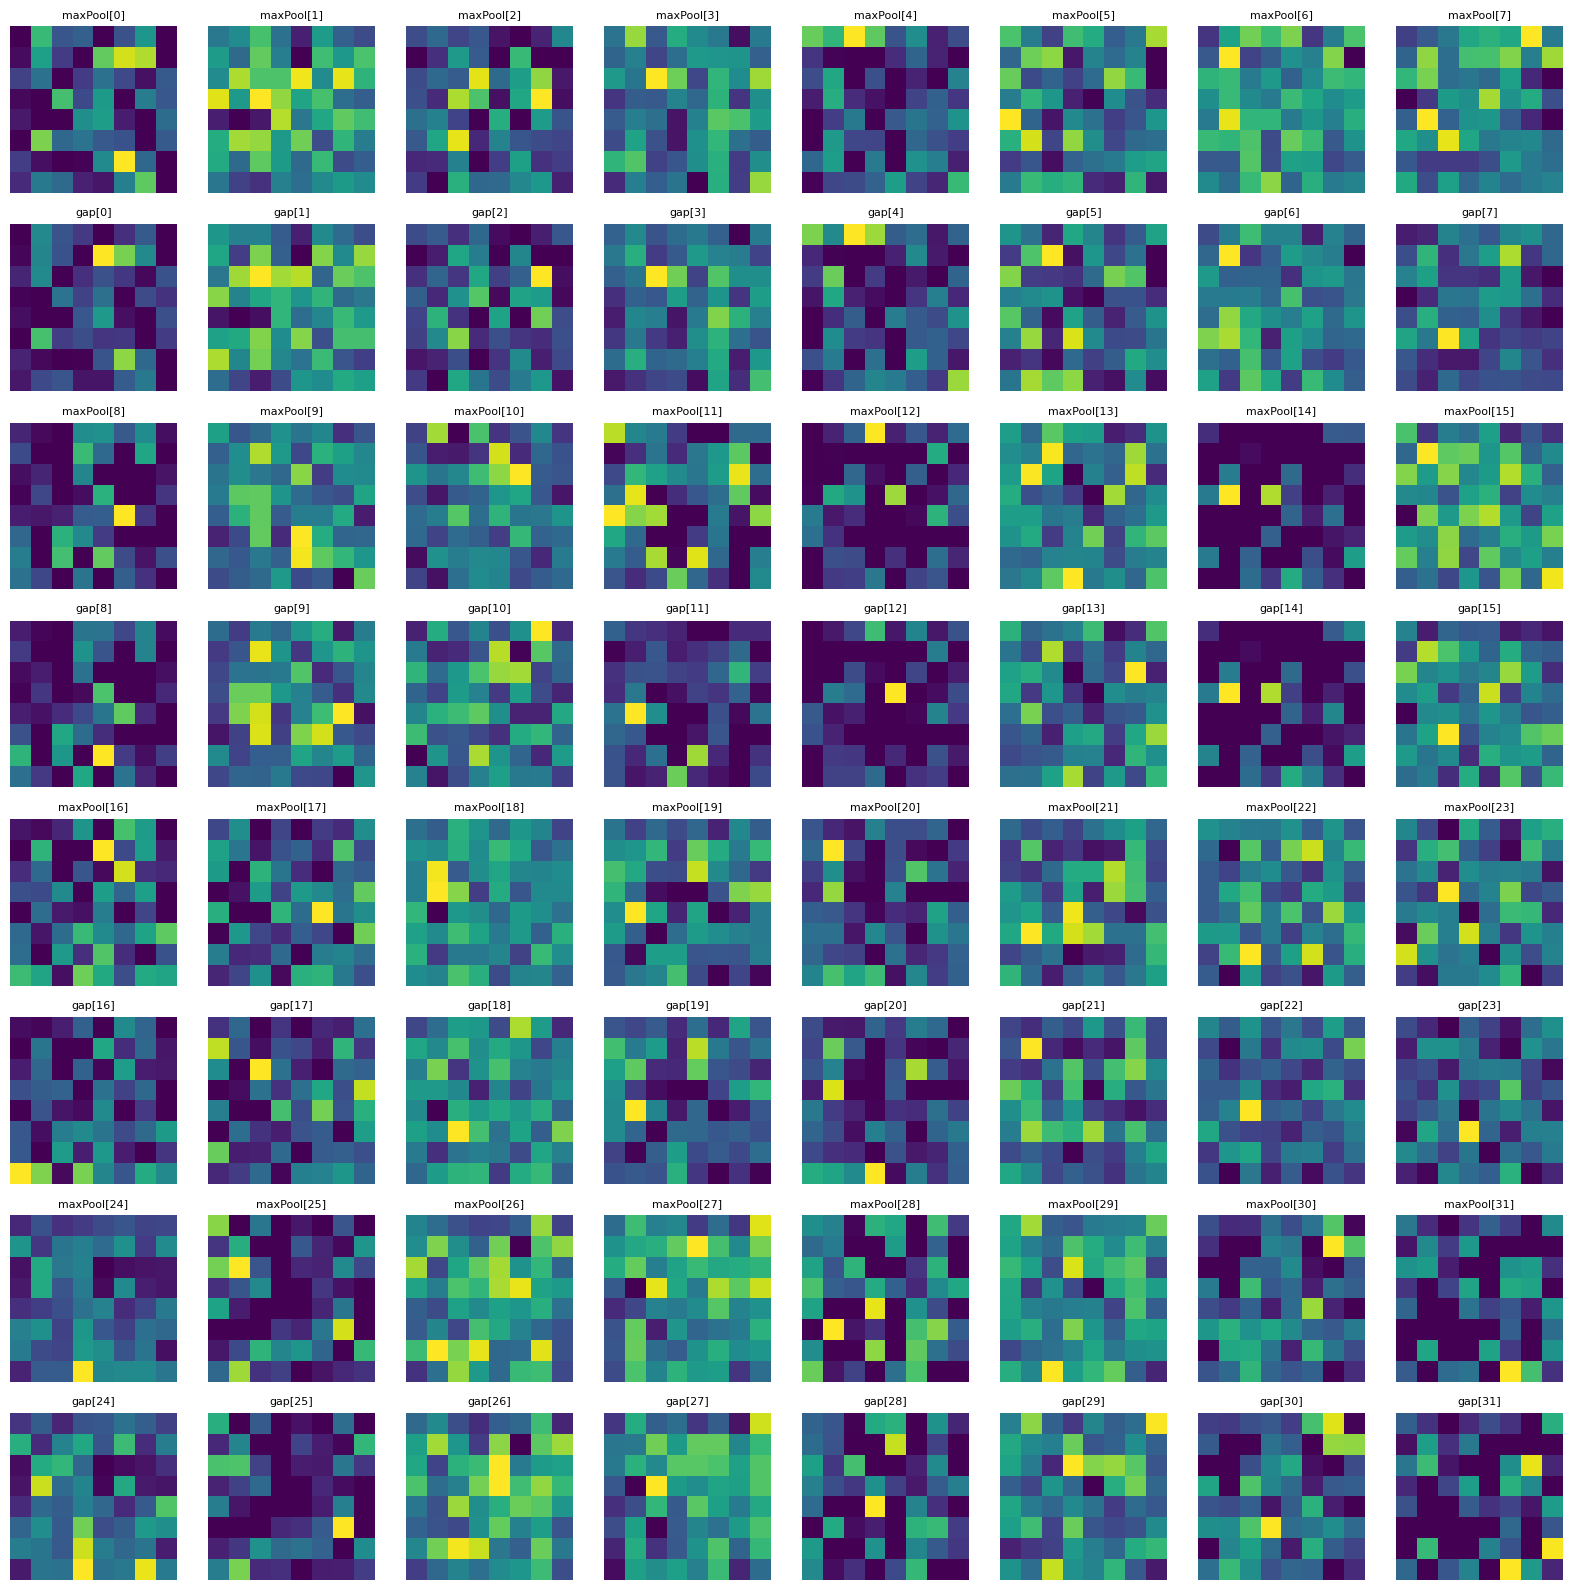

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import matplotlib.pyplot as plt
import numpy as np

maxPool = maxPool.detach().numpy()
gap = gap.detach().numpy()

fig, axs = plt.subplots(8, 8, figsize=(16, 16))

for group in range(4):
    for i in range(8):
        idx_maxPool = group * 8 + i
        idx_gap = group * 8 + i

        ax_maxPool = axs[group * 2, i]
        ax_maxPool.imshow(maxPool[idx_maxPool], cmap='viridis')
        ax_maxPool.set_title(f'maxPool[{idx_maxPool}]', fontsize=8)
        ax_maxPool.axis('off')

        ax_gap = axs[group * 2 + 1, i]
        ax_gap.imshow(gap[idx_gap], cmap='viridis')
        ax_gap.set_title(f'gap[{idx_gap}]', fontsize=8)
        ax_gap.axis('off')

plt.tight_layout()
plt.show()

Чтобы было проще сравнить, построим абсолютную разницу карт двух разных пулингов

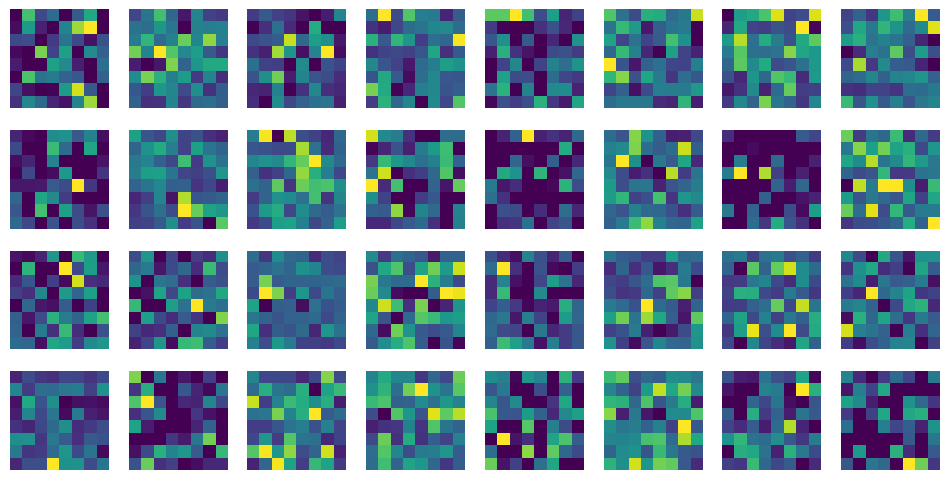

In [13]:
diff = np.abs(maxPool - gap)


fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for i in range(32):
    axes[i].imshow(diff[i])
    axes[i].axis('off')

plt.show()

Сравним среднее двух выходов:

In [14]:
print("Среднее maxPool: ", np.mean(maxPool))
print("Среднее gap: ", np.mean(gap))

Среднее maxPool:  0.23260796
Среднее gap:  0.10244528


Среднее maxPool получилось больше. Это может быть связано с тем, что maxPool выбирает наибольшие значения, тогда как gap делает усреднение, поэтому в среднем значения maxPool будут больше. Чтобы в этом убедиться, прогоним эксперименты несколько раз

In [17]:
exp_num = 10000
maxPoolVals = [0] * exp_num
gapVals = [0] * exp_num
for i in range(exp_num):
    tens = torch.randn(size=(3,64,64))
    mp, gap = model(tens)
    mp = mp.detach().numpy()
    gap = gap.detach().numpy()
    maxPoolVals[i] = np.mean(mp)
    gapVals[i] = np.mean(gap)


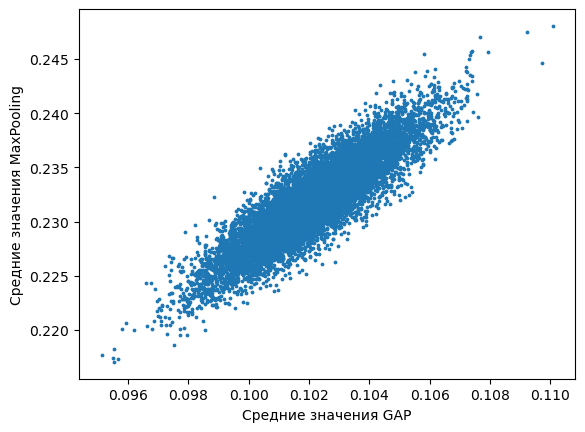

In [19]:
plt.scatter(gapVals, maxPoolVals,s=3)
plt.xlabel('Средние значения GAP')
plt.ylabel('Средние значения MaxPooling')
plt.show()

Видим, что средние значения MaxPooling всегда больше средних значений GAP